# Ноутбук 5: Multi-task на EMNIST - тонкая (62) + грубая (кластеризованные супер-классы)

**Цель:** Использовать многозадачность как регуляризацию и проверить, помогает ли "иерархическая" цель.

**Что делаем:**
1. Построение грубых классов через кластеризацию центроидов
2. Архитектура с двумя головами (62 класса + K супер-классов)
3. Балансировка лоссов (α и β)
4. Сравнение single-task vs multi-task
5. Опционально: добавление SupCon loss
6. Анализ влияния количества супер-классов K


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")


Using device: cuda
GPU: NVIDIA L40
GPU memory: 44.38 GB


## 1. Загрузка данных из baseline

Загружаем предобработанные данные из первого ноутбука.


In [2]:
# Загрузка данных из baseline
checkpoint_dir = Path("./checkpoints/baseline")
data_dir = checkpoint_dir / "data"

X_train = np.load(data_dir / "X_train_scaled.npy")
X_val = np.load(data_dir / "X_val_scaled.npy")
X_test = np.load(data_dir / "X_test_scaled.npy")
y_train = np.load(data_dir / "y_train.npy")
y_val = np.load(data_dir / "y_val.npy")
y_test = np.load(data_dir / "y_test.npy")

print(f"Данные загружены:")
print(f"  Train: {len(X_train):,}")
print(f"  Val: {len(X_val):,}")
print(f"  Test: {len(X_test):,}")
print(f"  Input dim: {X_train.shape[1]}")
print(f"  Classes: {len(np.unique(y_train))}")

n_classes = len(np.unique(y_train))
input_dim = X_train.shape[1]


Данные загружены:
  Train: 628,138
  Val: 69,794
  Test: 116,323
  Input dim: 784
  Classes: 62


## 2. Построение грубых классов (супер-классов)

Вычисляем центроиды признаков для каждого из 62 классов и кластеризуем их на K супер-классов. Это создает иерархическую структуру классов.


Вычисление центроидов классов...
  Вычислено центроидов: 62
Кластеризация 62 классов на 15 супер-классов...

Распределение по супер-классам:
  Супер-класс 0: 2 классов, 22,970 примеров
    Классы: [49, 53]
  Супер-класс 1: 4 классов, 39,772 примеров
    Классы: [2, 13, 35, 61]
  Супер-класс 2: 8 классов, 57,243 примеров
    Классы: [4, 29, 31, 33, 34, 57, 59, 60]
  Супер-класс 3: 2 классов, 6,652 примеров
    Классы: [32, 58]
  Супер-класс 4: 3 классов, 56,085 примеров
    Классы: [0, 24, 50]
  Супер-класс 5: 5 классов, 18,038 примеров
    Классы: [14, 20, 21, 27, 46]
  Супер-класс 6: 5 классов, 77,962 примеров
    Классы: [1, 18, 44, 47, 55]
  Супер-класс 7: 4 классов, 25,264 примеров
    Классы: [26, 30, 36, 56]
  Супер-класс 8: 3 классов, 33,822 примеров
    Классы: [12, 38, 40]
  Супер-класс 9: 5 классов, 54,181 примеров
    Классы: [6, 37, 39, 43, 45]
  Супер-класс 10: 7 классов, 90,161 примеров
    Классы: [3, 5, 11, 16, 19, 28, 54]
  Супер-класс 11: 2 классов, 10,483 примеров
  

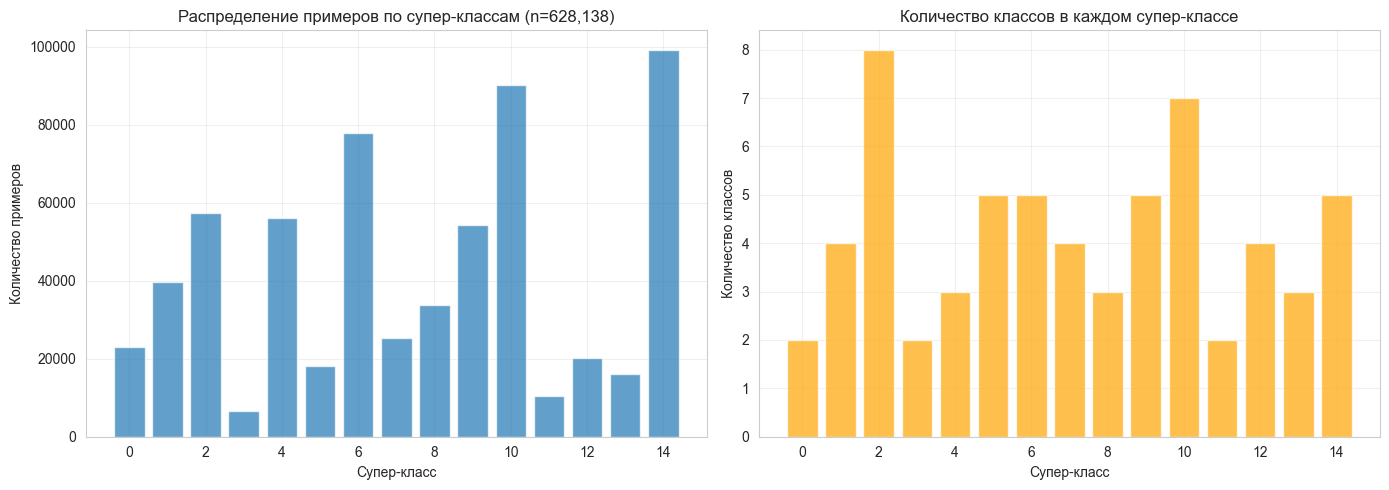

In [3]:
def compute_class_centroids(X, y, n_classes):
    """Вычисляет центроиды признаков для каждого класса"""
    centroids = []
    class_labels = []
    
    for cls in range(n_classes):
        class_mask = y == cls
        if class_mask.sum() > 0:
            class_data = X[class_mask]
            centroid = np.mean(class_data, axis=0)
            centroids.append(centroid)
            class_labels.append(cls)
    
    return np.array(centroids), np.array(class_labels)

def create_super_classes(centroids, class_labels, n_super_classes=15, random_state=42):
    """Кластеризует центроиды классов на супер-классы"""
    print(f"Кластеризация {len(centroids)} классов на {n_super_classes} супер-классов...")
    
    kmeans = KMeans(n_clusters=n_super_classes, random_state=random_state, n_init=10)
    super_class_labels = kmeans.fit_predict(centroids)
    
    # Создаем маппинг: класс -> супер-класс
    class_to_super = {}
    for cls, super_cls in zip(class_labels, super_class_labels):
        class_to_super[cls] = super_cls
    
    return super_class_labels, class_to_super, kmeans

# Вычисляем центроиды классов
print("Вычисление центроидов классов...")
centroids, class_labels_used = compute_class_centroids(X_train, y_train, n_classes)
print(f"  Вычислено центроидов: {len(centroids)}")

# Создаем супер-классы
n_super_classes = 15
super_class_labels, class_to_super, kmeans_super = create_super_classes(
    centroids, class_labels_used, n_super_classes=n_super_classes
)

# Создаем метки супер-классов для всех данных
y_train_super = np.array([class_to_super.get(cls, 0) for cls in y_train])
y_val_super = np.array([class_to_super.get(cls, 0) for cls in y_val])
y_test_super = np.array([class_to_super.get(cls, 0) for cls in y_test])

print(f"\nРаспределение по супер-классам:")
unique_super, counts_super = np.unique(y_train_super, return_counts=True)
for super_cls, count in zip(unique_super, counts_super):
    classes_in_super = [cls for cls, s in class_to_super.items() if s == super_cls]
    print(f"  Супер-класс {super_cls}: {len(classes_in_super)} классов, {count:,} примеров")
    print(f"    Классы: {classes_in_super[:10]}{'...' if len(classes_in_super) > 10 else ''}")

# Визуализация распределения
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(unique_super, counts_super, alpha=0.7)
axes[0].set_xlabel('Супер-класс')
axes[0].set_ylabel('Количество примеров')
axes[0].set_title(f'Распределение примеров по супер-классам (n={len(y_train_super):,})')
axes[0].grid(True, alpha=0.3)

# Количество классов в каждом супер-классе
classes_per_super = [len([cls for cls, s in class_to_super.items() if s == super_cls]) 
                      for super_cls in unique_super]
axes[1].bar(unique_super, classes_per_super, alpha=0.7, color='orange')
axes[1].set_xlabel('Супер-класс')
axes[1].set_ylabel('Количество классов')
axes[1].set_title('Количество классов в каждом супер-классе')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [4]:
class MLPEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dims=[512, 256, 128], dropout=0.3, embedding_dim=128):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim
        layers.append(nn.Linear(prev_dim, embedding_dim))
        self.encoder = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.encoder(x)

class MultiTaskModel(nn.Module):
    def __init__(self, input_dim, n_classes_fine, n_classes_coarse, 
                 hidden_dims=[512, 256, 128], dropout=0.3, embedding_dim=128):
        super().__init__()
        self.encoder = MLPEncoder(input_dim, hidden_dims, dropout, embedding_dim)
        self.head_fine = nn.Linear(embedding_dim, n_classes_fine)  # 62 класса
        self.head_coarse = nn.Linear(embedding_dim, n_classes_coarse)  # K супер-классов
    
    def forward(self, x, return_embeddings=False):
        embeddings = self.encoder(x)
        logits_fine = self.head_fine(embeddings)
        logits_coarse = self.head_coarse(embeddings)
        
        if return_embeddings:
            return logits_fine, logits_coarse, embeddings
        return logits_fine, logits_coarse

embedding_dim = 128
print(f"Архитектура Multi-Task модели:")
print(f"  Input dim: {input_dim}")
print(f"  Embedding dim: {embedding_dim}")
print(f"  Fine classes: {n_classes}")
print(f"  Coarse classes: {n_super_classes}")


Архитектура Multi-Task модели:
  Input dim: 784
  Embedding dim: 128
  Fine classes: 62
  Coarse classes: 15


## 4. SupCon Loss (опционально)

Реализуем Supervised Contrastive Loss для использования в комбинированном обучении.


In [5]:
class SupConLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature
    
    def forward(self, embeddings, labels):
        """
        Supervised Contrastive Loss
        embeddings: нормализованные эмбеддинги
        labels: метки классов
        """
        device = embeddings.device
        batch_size = embeddings.shape[0]
        
        # Маска для позитивных пар (одинаковые классы)
        mask = torch.eq(labels.unsqueeze(1), labels.unsqueeze(0)).float().to(device)
        
        # Нормализация эмбеддингов
        embeddings = F.normalize(embeddings, p=2, dim=1)
        
        # Вычисление сходств
        anchor_dot_contrast = torch.div(
            torch.matmul(embeddings, embeddings.T),
            self.temperature
        )
        
        # Стабилизация численная
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()
        
        # Вычисление вероятностей
        exp_logits = torch.exp(logits)
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True) + 1e-8)
        
        # Средний логарифм вероятности для позитивных пар
        mean_log_prob_pos = (mask * log_prob).sum(1) / (mask.sum(1) + 1e-8)
        
        loss = -mean_log_prob_pos.mean()
        return loss

print("SupCon Loss определен")


SupCon Loss определен


## 5. Функции обучения и оценки

Создаем функции для обучения multi-task моделей с балансировкой лоссов.


In [6]:
def train_epoch_mtl(model, dataloader, optimizer, criterion_fine, criterion_coarse,
                    device, alpha=1.0, beta=1.0, use_supcon=False, supcon_loss=None, 
                    lambda_supcon=0.0, labels_fine=None, labels_coarse=None):
    """Одна эпоха обучения multi-task модели"""
    model.train()
    total_loss = 0
    correct_fine = 0
    correct_coarse = 0
    total = 0
    
    for batch_idx, (X_batch, y_fine_batch, y_coarse_batch) in enumerate(tqdm(dataloader, leave=False)):
        X_batch = X_batch.to(device)
        y_fine_batch = y_fine_batch.to(device)
        y_coarse_batch = y_coarse_batch.to(device)
        
        optimizer.zero_grad()
        
        if use_supcon:
            logits_fine, logits_coarse, embeddings = model(X_batch, return_embeddings=True)
        else:
            logits_fine, logits_coarse = model(X_batch)
        
        loss_fine = criterion_fine(logits_fine, y_fine_batch)
        loss_coarse = criterion_coarse(logits_coarse, y_coarse_batch)
        
        loss = alpha * loss_fine + beta * loss_coarse
        
        if use_supcon and supcon_loss is not None:
            loss_supcon = supcon_loss(embeddings, y_fine_batch)
            loss = loss + lambda_supcon * loss_supcon
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted_fine = torch.max(logits_fine.data, 1)
        _, predicted_coarse = torch.max(logits_coarse.data, 1)
        total += y_fine_batch.size(0)
        correct_fine += (predicted_fine == y_fine_batch).sum().item()
        correct_coarse += (predicted_coarse == y_coarse_batch).sum().item()
    
    avg_loss = total_loss / len(dataloader)
    acc_fine = 100 * correct_fine / total
    acc_coarse = 100 * correct_coarse / total
    return avg_loss, acc_fine, acc_coarse

def evaluate_mtl(model, dataloader, device):
    """Оценка multi-task модели"""
    model.eval()
    all_preds_fine = []
    all_preds_coarse = []
    all_labels_fine = []
    all_labels_coarse = []
    
    with torch.no_grad():
        for X_batch, y_fine_batch, y_coarse_batch in dataloader:
            X_batch = X_batch.to(device)
            logits_fine, logits_coarse = model(X_batch)
            _, predicted_fine = torch.max(logits_fine.data, 1)
            _, predicted_coarse = torch.max(logits_coarse.data, 1)
            all_preds_fine.extend(predicted_fine.cpu().numpy())
            all_preds_coarse.extend(predicted_coarse.cpu().numpy())
            all_labels_fine.extend(y_fine_batch.numpy())
            all_labels_coarse.extend(y_coarse_batch.numpy())
    
    acc_fine = accuracy_score(all_labels_fine, all_preds_fine)
    f1_fine = f1_score(all_labels_fine, all_preds_fine, average='macro')
    acc_coarse = accuracy_score(all_labels_coarse, all_preds_coarse)
    f1_coarse = f1_score(all_labels_coarse, all_preds_coarse, average='macro')
    
    return acc_fine, f1_fine, acc_coarse, f1_coarse, all_preds_fine, all_labels_fine

def train_mtl_model(model, train_loader, val_loader, n_epochs=30, lr=0.001,
                   alpha=1.0, beta=1.0, use_supcon=False, lambda_supcon=0.0,
                   early_stopping_patience=5):
    """Полное обучение multi-task модели"""
    criterion_fine = nn.CrossEntropyLoss()
    criterion_coarse = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    supcon_loss = None
    if use_supcon:
        supcon_loss = SupConLoss(temperature=0.07)
    
    best_val_f1 = 0
    patience_counter = 0
    history = {
        'train_loss': [], 'train_acc_fine': [], 'train_acc_coarse': [],
        'val_acc_fine': [], 'val_f1_fine': [], 'val_acc_coarse': [], 'val_f1_coarse': []
    }
    
    for epoch in range(n_epochs):
        train_loss, train_acc_fine, train_acc_coarse = train_epoch_mtl(
            model, train_loader, optimizer, criterion_fine, criterion_coarse, device,
            alpha=alpha, beta=beta, use_supcon=use_supcon, supcon_loss=supcon_loss,
            lambda_supcon=lambda_supcon
        )
        
        val_acc_fine, val_f1_fine, val_acc_coarse, val_f1_coarse, _, _ = evaluate_mtl(
            model, val_loader, device
        )
        
        history['train_loss'].append(train_loss)
        history['train_acc_fine'].append(train_acc_fine)
        history['train_acc_coarse'].append(train_acc_coarse)
        history['val_acc_fine'].append(val_acc_fine)
        history['val_f1_fine'].append(val_f1_fine)
        history['val_acc_coarse'].append(val_acc_coarse)
        history['val_f1_coarse'].append(val_f1_coarse)
        
        if val_f1_fine > best_val_f1:
            best_val_f1 = val_f1_fine
            patience_counter = 0
        else:
            patience_counter += 1
        
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}: Train Loss={train_loss:.4f}, "
                  f"Fine Acc={train_acc_fine:.2f}%, Coarse Acc={train_acc_coarse:.2f}%, "
                  f"Val Fine F1={val_f1_fine:.4f}")
        
        if patience_counter >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    return history

print("Функции обучения определены")


Функции обучения определены


In [7]:
class MultiTaskDataset(Dataset):
    def __init__(self, X, y_fine, y_coarse):
        self.X = torch.FloatTensor(X)
        self.y_fine = torch.LongTensor(y_fine)
        self.y_coarse = torch.LongTensor(y_coarse)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y_fine[idx], self.y_coarse[idx]

train_dataset = MultiTaskDataset(X_train, y_train, y_train_super)
val_dataset = MultiTaskDataset(X_val, y_val, y_val_super)
test_dataset = MultiTaskDataset(X_test, y_test, y_test_super)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=4, pin_memory=True)

print("DataLoader'ы созданы")


DataLoader'ы созданы


## 7. Single-Task Baseline (только fine задача)

Обучаем модель только на задаче классификации 62 классов для сравнения.


In [8]:
print("="*60)
print("SINGLE-TASK BASELINE: Только fine задача (62 класса)")
print("="*60)

# Создаем модель только с fine головой
class SingleTaskModel(nn.Module):
    def __init__(self, input_dim, n_classes, hidden_dims=[512, 256, 128], 
                 dropout=0.3, embedding_dim=128):
        super().__init__()
        self.encoder = MLPEncoder(input_dim, hidden_dims, dropout, embedding_dim)
        self.head = nn.Linear(embedding_dim, n_classes)
    
    def forward(self, x):
        embeddings = self.encoder(x)
        logits = self.head(embeddings)
        return logits

model_single = SingleTaskModel(input_dim, n_classes, embedding_dim=embedding_dim).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_single.parameters(), lr=0.001)

best_val_f1 = 0
patience_counter = 0
history_single = {'train_loss': [], 'train_acc': [], 'val_acc': [], 'val_f1': []}

for epoch in range(30):
    model_single.train()
    train_loss = 0
    correct = 0
    total = 0
    
    for X_batch, y_fine_batch, _ in tqdm(train_loader, leave=False):
        X_batch = X_batch.to(device)
        y_fine_batch = y_fine_batch.to(device)
        
        optimizer.zero_grad()
        logits = model_single(X_batch)
        loss = criterion(logits, y_fine_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(logits.data, 1)
        total += y_fine_batch.size(0)
        correct += (predicted == y_fine_batch).sum().item()
    
    train_acc = 100 * correct / total
    train_loss = train_loss / len(train_loader)
    
    # Оценка на val
    model_single.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X_batch, y_fine_batch, _ in val_loader:
            X_batch = X_batch.to(device)
            logits = model_single(X_batch)
            _, predicted = torch.max(logits.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_fine_batch.numpy())
    
    val_acc = accuracy_score(all_labels, all_preds)
    val_f1 = f1_score(all_labels, all_preds, average='macro')
    
    history_single['train_loss'].append(train_loss)
    history_single['train_acc'].append(train_acc)
    history_single['val_acc'].append(val_acc)
    history_single['val_f1'].append(val_f1)
    
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        patience_counter = 0
    else:
        patience_counter += 1
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/30: Train Loss={train_loss:.4f}, "
              f"Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%, Val F1={val_f1:.4f}")
    
    if patience_counter >= 5:
        print(f"Early stopping at epoch {epoch+1}")
        break

# Оценка на test
model_single.eval()
all_preds_test = []
all_labels_test = []
with torch.no_grad():
    for X_batch, y_fine_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        logits = model_single(X_batch)
        _, predicted = torch.max(logits.data, 1)
        all_preds_test.extend(predicted.cpu().numpy())
        all_labels_test.extend(y_fine_batch.numpy())

single_test_acc = accuracy_score(all_labels_test, all_preds_test)
single_test_f1 = f1_score(all_labels_test, all_preds_test, average='macro')

print(f"\nSingle-Task на Test:")
print(f"  Accuracy: {single_test_acc:.4f}")
print(f"  Macro-F1: {single_test_f1:.4f}")

results = {
    'single_task': {'test_acc': single_test_acc, 'test_f1': single_test_f1}
}


SINGLE-TASK BASELINE: Только fine задача (62 класса)


Epoch 5/30: Train Loss=0.5255, Train Acc=82.14%, Val Acc=0.84%, Val F1=0.6806


Epoch 10/30: Train Loss=0.4788, Train Acc=83.39%, Val Acc=0.85%, Val F1=0.7012


Epoch 15/30: Train Loss=0.4578, Train Acc=83.96%, Val Acc=0.85%, Val F1=0.7042


Epoch 20/30: Train Loss=0.4438, Train Acc=84.33%, Val Acc=0.86%, Val F1=0.7050


Early stopping at epoch 21

Single-Task на Test:
  Accuracy: 0.8567
  Macro-F1: 0.6992


## 8. Multi-Task Learning (MTL) - балансировка лоссов

Обучаем multi-task модель с разными значениями α и β для балансировки лоссов.


In [9]:
# Эксперименты с разными значениями alpha и beta
alpha_beta_configs = [
    {'alpha': 1.0, 'beta': 0.5, 'name': 'MTL (α=1.0, β=0.5)'},
    {'alpha': 1.0, 'beta': 1.0, 'name': 'MTL (α=1.0, β=1.0)'},
    {'alpha': 1.0, 'beta': 2.0, 'name': 'MTL (α=1.0, β=2.0)'},
]

mtl_results = {}

for config in alpha_beta_configs:
    print("\n" + "="*60)
    print(f"MULTI-TASK LEARNING: {config['name']}")
    print("="*60)
    
    model_mtl = MultiTaskModel(input_dim, n_classes, n_super_classes, 
                               embedding_dim=embedding_dim).to(device)
    
    history_mtl = train_mtl_model(
        model_mtl, train_loader, val_loader,
        n_epochs=30, lr=0.001,
        alpha=config['alpha'], beta=config['beta']
    )
    
    test_acc_fine, test_f1_fine, test_acc_coarse, test_f1_coarse, _, _ = evaluate_mtl(
        model_mtl, test_loader, device
    )
    
    print(f"\n{config['name']} на Test:")
    print(f"  Fine - Accuracy: {test_acc_fine:.4f}, Macro-F1: {test_f1_fine:.4f}")
    print(f"  Coarse - Accuracy: {test_acc_coarse:.4f}, Macro-F1: {test_f1_coarse:.4f}")
    
    mtl_results[config['name']] = {
        'test_acc_fine': test_acc_fine,
        'test_f1_fine': test_f1_fine,
        'test_acc_coarse': test_acc_coarse,
        'test_f1_coarse': test_f1_coarse,
        'history': history_mtl
    }
    
    results[config['name']] = {'test_acc': test_acc_fine, 'test_f1': test_f1_fine}



MULTI-TASK LEARNING: MTL (α=1.0, β=0.5)


Epoch 5/30: Train Loss=0.6210, Fine Acc=82.02%, Coarse Acc=94.67%, Val Fine F1=0.6837


Epoch 10/30: Train Loss=0.5593, Fine Acc=83.25%, Coarse Acc=95.59%, Val Fine F1=0.6829


Epoch 15/30: Train Loss=0.5315, Fine Acc=83.83%, Coarse Acc=95.96%, Val Fine F1=0.7010


Epoch 20/30: Train Loss=0.5124, Fine Acc=84.23%, Coarse Acc=96.23%, Val Fine F1=0.7106


Epoch 25/30: Train Loss=0.5021, Fine Acc=84.40%, Coarse Acc=96.40%, Val Fine F1=0.7031
Early stopping at epoch 25

MTL (α=1.0, β=0.5) на Test:
  Fine - Accuracy: 0.8567, Macro-F1: 0.7022
  Coarse - Accuracy: 0.9713, Macro-F1: 0.9652

MULTI-TASK LEARNING: MTL (α=1.0, β=1.0)


Epoch 5/30: Train Loss=0.7161, Fine Acc=81.80%, Coarse Acc=94.84%, Val Fine F1=0.6800


Epoch 10/30: Train Loss=0.6370, Fine Acc=83.08%, Coarse Acc=95.75%, Val Fine F1=0.6904


Epoch 15/30: Train Loss=0.6004, Fine Acc=83.62%, Coarse Acc=96.14%, Val Fine F1=0.6885


Epoch 20/30: Train Loss=0.5795, Fine Acc=83.95%, Coarse Acc=96.37%, Val Fine F1=0.6925


Epoch 25/30: Train Loss=0.5657, Fine Acc=84.17%, Coarse Acc=96.51%, Val Fine F1=0.7020


Early stopping at epoch 28

MTL (α=1.0, β=1.0) на Test:
  Fine - Accuracy: 0.8555, Macro-F1: 0.6997
  Coarse - Accuracy: 0.9723, Macro-F1: 0.9664

MULTI-TASK LEARNING: MTL (α=1.0, β=2.0)


Epoch 5/30: Train Loss=0.9039, Fine Acc=81.35%, Coarse Acc=94.91%, Val Fine F1=0.6644


Epoch 10/30: Train Loss=0.7915, Fine Acc=82.64%, Coarse Acc=95.82%, Val Fine F1=0.6776


Epoch 15/30: Train Loss=0.7381, Fine Acc=83.27%, Coarse Acc=96.23%, Val Fine F1=0.6818


Early stopping at epoch 18

MTL (α=1.0, β=2.0) на Test:
  Fine - Accuracy: 0.8520, Macro-F1: 0.6900
  Coarse - Accuracy: 0.9711, Macro-F1: 0.9647


## 9. MTL + SupCon (комбинированный loss)

Добавляем SupCon loss к multi-task обучению для улучшения эмбеддингов.


In [10]:
print("\n" + "="*60)
print("MULTI-TASK + SUPCON: Комбинированный loss")
print("="*60)

lambda_supcon = 0.1
alpha = 1.0
beta = 1.0

model_mtl_supcon = MultiTaskModel(input_dim, n_classes, n_super_classes, 
                                  embedding_dim=embedding_dim).to(device)

history_mtl_supcon = train_mtl_model(
    model_mtl_supcon, train_loader, val_loader,
    n_epochs=30, lr=0.001,
    alpha=alpha, beta=beta,
    use_supcon=True, lambda_supcon=lambda_supcon
)

test_acc_fine, test_f1_fine, test_acc_coarse, test_f1_coarse, _, _ = evaluate_mtl(
    model_mtl_supcon, test_loader, device
)

print(f"\nMTL + SupCon на Test:")
print(f"  Fine - Accuracy: {test_acc_fine:.4f}, Macro-F1: {test_f1_fine:.4f}")
print(f"  Coarse - Accuracy: {test_acc_coarse:.4f}, Macro-F1: {test_f1_coarse:.4f}")

results['MTL + SupCon'] = {'test_acc': test_acc_fine, 'test_f1': test_f1_fine}



MULTI-TASK + SUPCON: Комбинированный loss


Epoch 5/30: Train Loss=1.0712, Fine Acc=81.83%, Coarse Acc=94.92%, Val Fine F1=0.6848


Epoch 10/30: Train Loss=0.9843, Fine Acc=83.15%, Coarse Acc=95.80%, Val Fine F1=0.6893


Epoch 15/30: Train Loss=0.9459, Fine Acc=83.66%, Coarse Acc=96.17%, Val Fine F1=0.6891


Early stopping at epoch 16

MTL + SupCon на Test:
  Fine - Accuracy: 0.8526, Macro-F1: 0.6932
  Coarse - Accuracy: 0.9710, Macro-F1: 0.9647


## 10. Сравнение всех методов

Создаем итоговую таблицу сравнения всех методов.


ИТОГОВОЕ СРАВНЕНИЕ МЕТОДОВ
            Method  Accuracy  Macro-F1
MTL (α=1.0, β=0.5)  0.856684  0.702196
MTL (α=1.0, β=1.0)  0.855532  0.699695
       single_task  0.856701  0.699187
      MTL + SupCon  0.852617  0.693186
MTL (α=1.0, β=2.0)  0.851990  0.689994

Результаты сохранены в checkpoints/multi_task


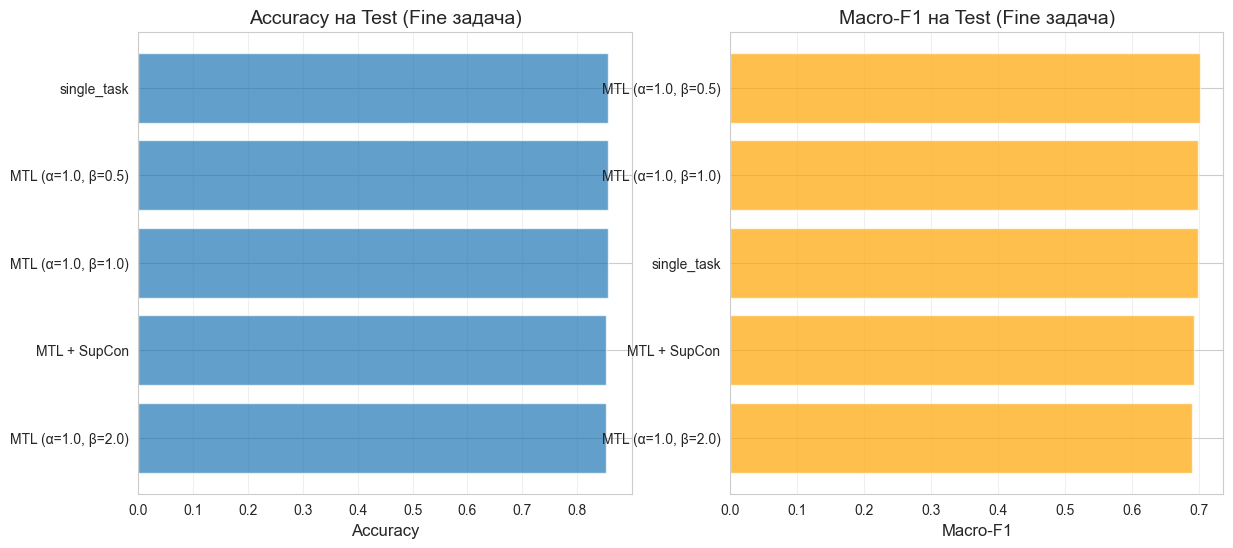

In [12]:
# Создание итоговой таблицы
comparison_data = []
for method_name, metrics in results.items():
    comparison_data.append({
        'Method': method_name,
        'Accuracy': metrics['test_acc'],
        'Macro-F1': metrics['test_f1']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Macro-F1', ascending=False)

print("=" * 80)
print("ИТОГОВОЕ СРАВНЕНИЕ МЕТОДОВ")
print("=" * 80)
print(comparison_df.to_string(index=False))

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy
ax = axes[0]
comparison_df_sorted = comparison_df.sort_values('Accuracy', ascending=True)
ax.barh(comparison_df_sorted['Method'], comparison_df_sorted['Accuracy'], alpha=0.7)
ax.set_xlabel('Accuracy', fontsize=12)
ax.set_title('Accuracy на Test (Fine задача)', fontsize=14)
ax.grid(True, alpha=0.3, axis='x')

# Macro-F1
ax = axes[1]
comparison_df_sorted = comparison_df.sort_values('Macro-F1', ascending=True)
ax.barh(comparison_df_sorted['Method'], comparison_df_sorted['Macro-F1'], alpha=0.7, color='orange')
ax.set_xlabel('Macro-F1', fontsize=12)
ax.set_title('Macro-F1 на Test (Fine задача)', fontsize=14)
ax.grid(True, alpha=0.3, axis='x')


# Сохранение результатов
save_dir = Path("./checkpoints/multi_task")
save_dir.mkdir(parents=True, exist_ok=True)

comparison_df.to_csv(save_dir / "comparison_results.csv", index=False)

with open(save_dir / "all_results.pkl", "wb") as f:
    pickle.dump(results, f)

print(f"\nРезультаты сохранены в {save_dir}")


## 11. Абляция: влияние количества супер-классов K

Исследуем влияние количества супер-классов на производительность модели.


АБЛЯЦИЯ: Влияние количества супер-классов K

K = 5 супер-классов:
Кластеризация 62 классов на 5 супер-классов...


Epoch 5/25: Train Loss=0.6704, Fine Acc=81.91%, Coarse Acc=95.74%, Val Fine F1=0.6788


Epoch 10/25: Train Loss=0.6038, Fine Acc=83.08%, Coarse Acc=96.40%, Val Fine F1=0.6947


Epoch 15/25: Train Loss=0.5733, Fine Acc=83.64%, Coarse Acc=96.71%, Val Fine F1=0.6937


Epoch 20/25: Train Loss=0.5532, Fine Acc=84.00%, Coarse Acc=96.90%, Val Fine F1=0.7052


Epoch 25/25: Train Loss=0.5382, Fine Acc=84.22%, Coarse Acc=97.03%, Val Fine F1=0.7058
  Accuracy: 0.8554, F1: 0.7085

K = 10 супер-классов:
Кластеризация 62 классов на 10 супер-классов...


Epoch 5/25: Train Loss=0.6983, Fine Acc=81.74%, Coarse Acc=95.34%, Val Fine F1=0.6696


Epoch 10/25: Train Loss=0.6212, Fine Acc=83.04%, Coarse Acc=96.19%, Val Fine F1=0.6967


Epoch 15/25: Train Loss=0.5859, Fine Acc=83.62%, Coarse Acc=96.54%, Val Fine F1=0.6976


Early stopping at epoch 18
  Accuracy: 0.8542, F1: 0.6969

K = 15 супер-классов:
Кластеризация 62 классов на 15 супер-классов...


Epoch 5/25: Train Loss=0.7150, Fine Acc=81.79%, Coarse Acc=94.88%, Val Fine F1=0.6798


Epoch 10/25: Train Loss=0.6368, Fine Acc=83.04%, Coarse Acc=95.72%, Val Fine F1=0.6884


Epoch 15/25: Train Loss=0.6002, Fine Acc=83.60%, Coarse Acc=96.14%, Val Fine F1=0.6944


Early stopping at epoch 19
  Accuracy: 0.8549, F1: 0.6954

K = 20 супер-классов:
Кластеризация 62 классов на 20 супер-классов...


Epoch 5/25: Train Loss=0.7404, Fine Acc=81.91%, Coarse Acc=93.94%, Val Fine F1=0.6726


Epoch 10/25: Train Loss=0.6598, Fine Acc=83.10%, Coarse Acc=94.87%, Val Fine F1=0.6810


Epoch 15/25: Train Loss=0.6217, Fine Acc=83.75%, Coarse Acc=95.37%, Val Fine F1=0.6990


Epoch 20/25: Train Loss=0.5995, Fine Acc=84.08%, Coarse Acc=95.60%, Val Fine F1=0.6930


Epoch 25/25: Train Loss=0.5827, Fine Acc=84.31%, Coarse Acc=95.81%, Val Fine F1=0.7004
  Accuracy: 0.8563, F1: 0.7005

K = 25 супер-классов:
Кластеризация 62 классов на 25 супер-классов...


Epoch 5/25: Train Loss=0.7494, Fine Acc=81.86%, Coarse Acc=93.70%, Val Fine F1=0.6737


Epoch 10/25: Train Loss=0.6669, Fine Acc=83.14%, Coarse Acc=94.70%, Val Fine F1=0.6873


Epoch 15/25: Train Loss=0.6288, Fine Acc=83.72%, Coarse Acc=95.19%, Val Fine F1=0.6889


Epoch 20/25: Train Loss=0.6052, Fine Acc=84.09%, Coarse Acc=95.45%, Val Fine F1=0.7023


Epoch 25/25: Train Loss=0.5895, Fine Acc=84.26%, Coarse Acc=95.62%, Val Fine F1=0.6978
Early stopping at epoch 25
  Accuracy: 0.8562, F1: 0.6981

 k  accuracy       f1
 5  0.855446 0.708463
10  0.854242 0.696856
15  0.854930 0.695363
20  0.856322 0.700545
25  0.856202 0.698075


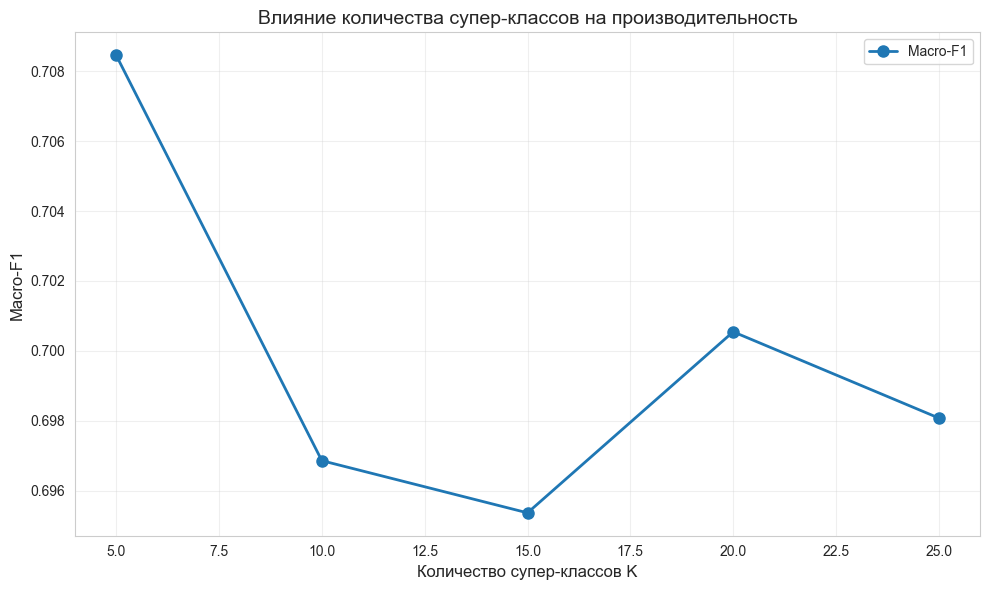

In [13]:
print("="*60)
print("АБЛЯЦИЯ: Влияние количества супер-классов K")
print("="*60)

k_values = [5, 10, 15, 20, 25]
ablation_k = []

for k in k_values:
    print(f"\nK = {k} супер-классов:")
    
    # Создаем новые супер-классы
    _, class_to_super_k, _ = create_super_classes(
        centroids, class_labels_used, n_super_classes=k
    )
    
    y_train_super_k = np.array([class_to_super_k.get(cls, 0) for cls in y_train])
    y_val_super_k = np.array([class_to_super_k.get(cls, 0) for cls in y_val])
    y_test_super_k = np.array([class_to_super_k.get(cls, 0) for cls in y_test])
    
    # Создаем DataLoader
    train_dataset_k = MultiTaskDataset(X_train, y_train, y_train_super_k)
    val_dataset_k = MultiTaskDataset(X_val, y_val, y_val_super_k)
    test_dataset_k = MultiTaskDataset(X_test, y_test, y_test_super_k)
    
    train_loader_k = DataLoader(train_dataset_k, batch_size=512, shuffle=True, num_workers=4, pin_memory=True)
    val_loader_k = DataLoader(val_dataset_k, batch_size=512, shuffle=False, num_workers=4, pin_memory=True)
    test_loader_k = DataLoader(test_dataset_k, batch_size=512, shuffle=False, num_workers=4, pin_memory=True)
    
    # Обучаем модель
    model_k = MultiTaskModel(input_dim, n_classes, k, embedding_dim=embedding_dim).to(device)
    history_k = train_mtl_model(
        model_k, train_loader_k, val_loader_k,
        n_epochs=25, lr=0.001,
        alpha=1.0, beta=1.0
    )
    
    test_acc_fine, test_f1_fine, _, _, _, _ = evaluate_mtl(model_k, test_loader_k, device)
    
    ablation_k.append({
        'k': k,
        'accuracy': test_acc_fine,
        'f1': test_f1_fine
    })
    
    print(f"  Accuracy: {test_acc_fine:.4f}, F1: {test_f1_fine:.4f}")

ablation_k_df = pd.DataFrame(ablation_k)
print("\n" + ablation_k_df.to_string(index=False))

# Визуализация
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(ablation_k_df['k'], ablation_k_df['f1'], marker='o', linewidth=2, markersize=8, label='Macro-F1')
ax.set_xlabel('Количество супер-классов K', fontsize=12)
ax.set_ylabel('Macro-F1', fontsize=12)
ax.set_title('Влияние количества супер-классов на производительность', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()
